## Практика построения регрессии

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**1.** Давайте проанализируем данные опроса 4361 женщин из Ботсваны:

О каждой из них мы знаем:

- сколько детей она родила (признак ceb)
- возраст (age)
- длительность получения образования (educ)
- религиозная принадлежность (religion)
- идеальное, по её мнению, количество детей в семье (idlnchld)
- была ли она когда-нибудь замужем (evermarr)
- возраст первого замужества (agefm)
- длительность получения образования мужем (heduc)
- знает ли она о методах контрацепции (knowmeth)
- использует ли она методы контрацепции (usemeth)
- живёт ли она в городе (urban)
- есть ли у неё электричество, радио, телевизор и велосипед (electric, radio, tv, bicycle)

Давайте научимся оценивать количество детей ceb по остальным признакам.

Загрузите данные и внимательно изучите их. Сколько разных значений принимает признак religion?

In [5]:
data = pd.read_csv('data/botswana.tsv', sep='\t', header=0)
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [11]:
data['religion'].value_counts()

spirit        1841
other         1080
protestant     993
catholic       447
Name: religion, dtype: int64

**2.** Во многих признаках есть пропущенные значения. Сколько объектов из 4361 останется, если выбросить все, содержащие пропуски? 

In [12]:
data.dropna().count()

ceb         1834
age         1834
educ        1834
religion    1834
idlnchld    1834
knowmeth    1834
usemeth     1834
evermarr    1834
agefm       1834
heduc       1834
urban       1834
electric    1834
radio       1834
tv          1834
bicycle     1834
dtype: int64

**3.** В разных признаках пропуски возникают по разным причинам и должны обрабатываться по-разному. 

Например, в признаке *agefm* пропуски стоят только там, где $evermarr=0$, то есть, они соответствуют женщинам, никогда не выходившим замуж. Таким образом, для этого признака *NaN* соответствует значению "не применимо". 

В подобных случаях, когда признак $x_1$ на части объектов в принципе не может принимать никакие значения, рекомендуется поступать так:

* создать новый бинарный признак 
$$ \begin{equation*}
x_2 = 
 \begin{cases}
   1, &\text{$x_1$ = 'не применимо'}\\
   0, &\text{иначе}
 \end{cases}
\end{equation*} $$

* заменить "не применимо" в $x_1$ на произвольную константу $c$, которая среди других значений $x_1$ не встречается.

Теперь, когда мы построим регрессию на оба признака и получим модель вида 
$$y=\beta_0 + \beta_1 x_1 + \beta_2 x_2,$$
на тех объектах, где $x_1$ было измерено, регрессионное уравнение примет вид 
$$y=\beta_0 + \beta_1 x,$$
а там, где $x_1$ было "не применимо", получится 
$$y=\beta_0 + \beta_1 c + \beta_2.$$
Выбор $c$ влияет только на значение и интерпретацию $\beta_2$, но не $\beta_1$.

Давайте используем этот метод для обработки пропусков в *agefm* и *heduc*.

1. Создайте признак *nevermarr*, равный единице там, где в *agefm* пропуски.
1. Удалите признак *evermarr* — в сумме с nevermarr он даёт константу, значит, в нашей матрице *X* будет мультиколлинеарность.
1. Замените *NaN* в признаке *agefm* на $c_{agefm}=0$.
1. У объектов, где $nevermarr = 1$, замените *NaN* в признаке *heduc* на $c_{heduc_1}=-1$ (ноль использовать нельзя, так как он уже встречается у некоторых объектов выборки).
Сколько осталось пропущенных значений в признаке heduc?

In [13]:
data['nevermarr'] = data['agefm'].apply(lambda x: 1 if np.isnan(x) else 0)
data.drop(columns=['evermarr'], inplace=True)
data['agefm'].fillna(0, inplace=True)

In [15]:
data['heduc'] = data.apply(lambda x: -1 if (x['nevermarr']==1 and np.isnan(x['heduc'])) else x['heduc'], axis=1)

In [16]:
np.isnan(data['heduc']).value_counts()

False    4238
True      123
Name: heduc, dtype: int64

**4.** Избавимся от оставшихся пропусков.

Для признаков *idlnchld, heduc* и *usemeth* проведите операцию, аналогичную предыдущей: создайте индикаторы пропусков по этим признакам *(idlnchld_noans, heduc_noans, usemeth_noans)*, замените пропуски на нехарактерные значения ($c_{idlnchld}=-1$, $c_{heduc_2}=-2$(значение -1 мы уже использовали), $c_{usemeth}=-1$.

Остались только пропуски в признаках knowmeth, electric, radio, tv и bicycle. Их очень мало, так что удалите объекты, на которых их значения пропущены.

Какого размера теперь наша матрица данных? Умножьте количество строк на количество всех столбцов (включая отклик ceb).

In [19]:
data['idlnchld_noans'] = data['idlnchld'].apply(lambda x: 1 if np.isnan(x) else 0)
data['heduc_noans'] = data['heduc'].apply(lambda x: 1 if np.isnan(x) else 0)
data['usemeth_noans'] = data['usemeth'].apply(lambda x: 1 if np.isnan(x) else 0)
data['idlnchld'].fillna(-1, inplace=True)
data['heduc'].fillna(-2, inplace=True)
data['usemeth'].fillna(-1, inplace=True)

In [20]:
data.dropna(inplace=True)

In [22]:
data.shape[0]*data.shape[1]

78264

**5.** Постройте регрессию количества детей *ceb* на все имеющиеся признаки методом *smf.ols*, как в разобранном до этого примере. Какой получился коэффициент детерминации $R^2$? Округлите до трёх знаков после десятичной точки.

In [40]:
'+'.join(data.columns[1:])

'age+educ+religion+idlnchld+knowmeth+usemeth+agefm+heduc+urban+electric+radio+tv+bicycle+nevermarr+idlnchld_noans+heduc_noans+usemeth_noans'

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Tue, 29 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:53:57   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

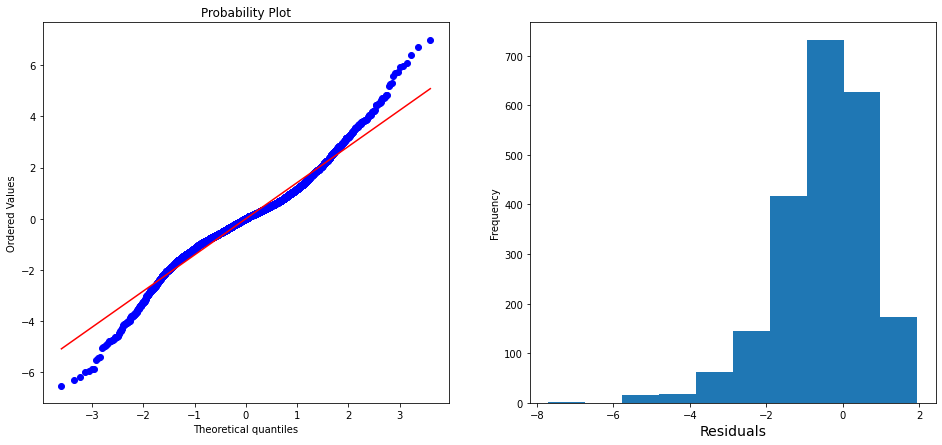

In [58]:
formula = data.columns[0] + ' ~ ' + '+'.join(data.columns[1:])
m1 = smf.ols(formula = formula, data=data)
fitted = m1.fit()
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

**7.** Проверьте критерием Бройша-Пагана гомоскедастичность ошибки в построенной модели. Выполняется ли она?

Если ошибка гетероскедастична, перенастройте модель, сделав поправку Уайта типа HC1. 

In [57]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


* Ошибка гетероскедастична, $p\leq0.05$, нужно делать поправку Уайта

**8.** Удалите из модели незначимые признаки *religion, radio* и *tv*. Проверьте гомоскедастичность ошибки, при необходимости сделайте поправку Уайта. 

Не произошло ли значимого ухудшения модели после удаления этой группы признаков? Проверьте с помощью критерия Фишера. Чему равен его достигаемый уровень значимости? Округлите до четырёх цифр после десятичной точки.

Если достигаемый уровень значимости получился маленький, верните все удалённые признаки; если он достаточно велик, оставьте модель без религии, тв и радио.

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     559.5
Date:                Tue, 29 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:55:09   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.198     -5.

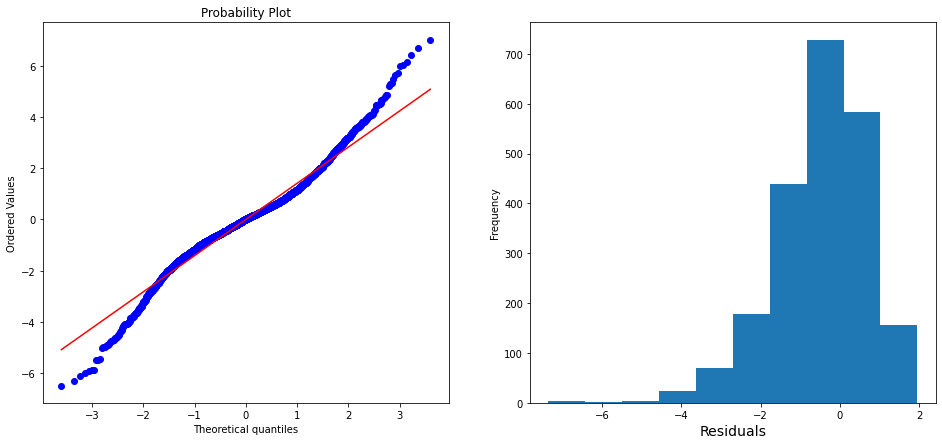

In [59]:
m2 = smf.ols(formula = 'ceb ~ age+educ+idlnchld+knowmeth+usemeth+'\
             'agefm+heduc+urban+electric+bicycle+nevermarr+'\
             'idlnchld_noans+heduc_noans+usemeth_noans', data=data)
fitted = m2.fit()
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [60]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Tue, 29 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:56:17   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

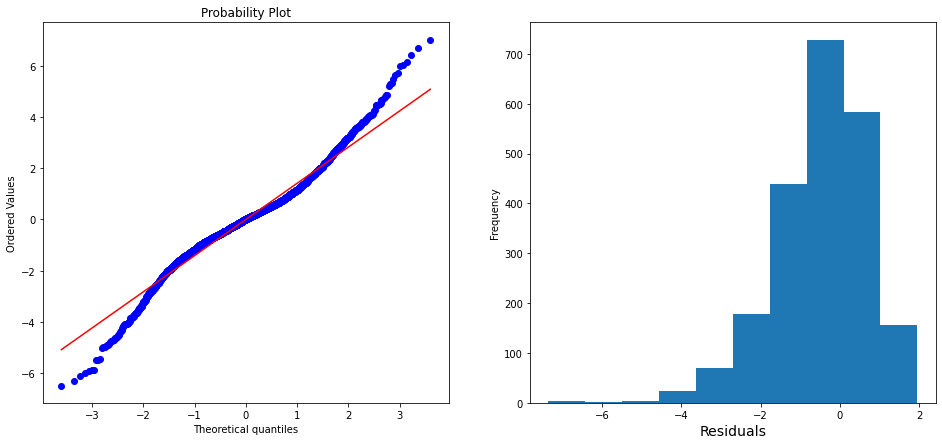

In [61]:
m2 = smf.ols(formula = 'ceb ~ age+educ+idlnchld+knowmeth+usemeth+'\
             'agefm+heduc+urban+electric+bicycle+nevermarr+'\
             'idlnchld_noans+heduc_noans+usemeth_noans', data=data)
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [62]:
print("F=%f, p=%f, k1=%f" % m1.fit().compare_f_test(m2.fit()))

F=0.919236, p=0.467231, k1=5.000000


In [63]:
m3 = smf.ols(formula = 'ceb ~ age+educ+idlnchld+knowmeth+'\
             'agefm+heduc+urban+electric+bicycle+nevermarr+'\
             'idlnchld_noans+heduc_noans', data=data)
fitted = m3.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     396.4
Date:                Tue, 29 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:59:24   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.262     -4.

In [66]:
print(f'p = {m2.fit().compare_f_test(m3.fit())[1]}')

p = 3.155200948041877e-40


**10.** Посмотрите на доверительные интервалы для коэффициентов итоговой модели (не забудьте использовать поправку Уайта, если есть гетероскедастичность ошибки) и выберите правильные выводы.
* У женщин, не знающих, какое количество детей идеально, в среднем на $\beta_{idlnchld\_noans} + c_{idlnchld} \beta_{idlnchld} \approx 0.58$ детей больше
* Итоговая модель объясняет 64.4% вариации отклика ($R^2$)
* С увеличением возраста женщины на 1 год среднее количество детей возрастает на 0.17 (p<0.001, 95% доверительный интервал — [0.16, 0.18])
* У женщин, никогда не выходивших замуж, при прочих равных в среднем на 2.3 ребёнка меньше (p<0.001, 95% доверительный интервал для разницы между средними — [-2.6, -1.9])